In [1]:
%load_ext autoreload

In [81]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from scipy import spatial
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

# Load Some Data

In [3]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
areas = np.hstack([areas, 'all'])

# Load Directory

In [7]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

In [8]:
def load_window_from_chunks(window_start, window_end, directory, dimension_inds=None):
    dt = directory.end_time.iloc[0]/directory.end_ind.iloc[0]
    window_start = int(window_start/dt)
    window_end = int(window_end/dt)
    
    start_time_bool = directory.start_ind <= window_start
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(directory) else len(directory) - 1
    end_time_bool = directory.end_ind > window_end
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(directory) - 1
    
    window_data = None
    
    pos_in_window = 0
    for row_ind in range(start_row, end_row + 1):
        row = directory.iloc[row_ind]
        chunk = pd.read_pickle(row.filepath)
        if dimension_inds is None:
            dimension_inds = np.arange(chunk.shape[1])
        if window_data is None:
            window_data = np.zeros((window_end - window_start, len(dimension_inds)))
                
        if row.start_ind <= window_start:
            start_in_chunk = window_start - row.start_ind
        else:
            start_in_chunk = 0

        if row.end_ind <= window_end:
            end_in_chunk = chunk.shape[0]
        else:
            end_in_chunk = window_end - row.start_ind

        window_data[pos_in_window:pos_in_window + end_in_chunk - start_in_chunk] = chunk[start_in_chunk:end_in_chunk, dimension_inds]
        pos_in_window += end_in_chunk - start_in_chunk
                
    return window_data

# Load Data

In [9]:
session_info['drugStart']

array([1155.19066667, 2955.19066667])

In [10]:
wake_t = 300
anesthesia_t = 3000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [11]:
wake_signal = load_window_from_chunks(wake_t, wake_t + 20, directory, unit_indices)
# wake_signal_unnormed = deepcopy(wake_signal)
# wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 20, directory, unit_indices)
# anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
# anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()

# Pick Rank

In [12]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )
parameter_grid = ParameterGrid(
    window_vals=np.array([15000]),
    matrix_size_vals=np.array([100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000]),
    reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
)
exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 0.9999])

In [13]:
def compute_explained_variance(S):
    return torch.cumsum(S**2/((S**2).sum()), 0)

In [14]:
prediction_time = 5000

In [68]:
results = []
iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(exp_variance_vals))
for window in parameter_grid.window_vals:
    for matrix_size in parameter_grid.matrix_size_vals:
        delase_wake = DeLASE(wake_signal[:window], matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda')
        delase_anesthesia = DeLASE(anesthesia_signal[:window], matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda')
       
        exp_variance_wake = compute_explained_variance(delase_wake.S.cpu())
        exp_variance_anesthesia = compute_explained_variance(delase_anesthesia.S.cpu())
        for thresh in exp_variance_vals:
            r = np.max([int(np.argmax(exp_variance_wake > thresh)), int(np.argmax(exp_variance_anesthesia > thresh))])
            delase_wake.compute_havok_dmd(r=r)
            delase_wake.get_stability(max_freq=500, max_unstable_freq=125)
            delase_anesthesia.compute_havok_dmd(r=r)
            delase_anesthesia.get_stability(max_freq=500, max_unstable_freq=125)
            
            ip_wake = compute_integrated_performance(delase_wake, wake_signal[window:window + prediction_time], full_return=True)
            ip_anesthesia = compute_integrated_performance(delase_anesthesia, anesthesia_signal[window:window + prediction_time], full_return=True)
            
            results.append(dict(
                window=window,
                matrix_size=matrix_size,
                exp_variance_wake=exp_variance_wake,
                exp_variance_anesthesia=exp_variance_anesthesia,
                exp_variance_thresh=thresh,
                r=r,
                ip_wake=ip_wake,
                ip_anesthesia=ip_anesthesia,
                stab_wake=delase_wake.stability_params.cpu(),
                freqs_wake=delase_wake.stability_freqs.cpu(),
                stab_anesthesia=delase_anesthesia.stability_params.cpu(),
                freqs_anesthesia=delase_anesthesia.stability_freqs.cpu(),
            ))
            
            pd.to_pickle(results, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_wake_anesthesia_r_comparison.pkl'))
            
            iterator.update()
iterator.close()

  0%|          | 0/162 [00:00<?, ?it/s]

In [69]:
results = pd.DataFrame(results)

In [70]:
matrix_size_vals = results.matrix_size.unique()
exp_variance_thresh_vals = results.exp_variance_thresh.unique()

In [71]:
wake_ip = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
anesthesia_ip = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
wake_stab = {}
anesthesia_stab = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.exp_variance_thresh == exp_variance_thresh)].iloc[0]
        wake_ip[i, j] = row.ip_wake['ip']
        anesthesia_ip[i, j] = row.ip_anesthesia['ip']
        wake_stab[(matrix_size, exp_variance_thresh)] = row.stab_wake.cpu()
        anesthesia_stab[(matrix_size, exp_variance_thresh)] = row.stab_anesthesia.cpu()

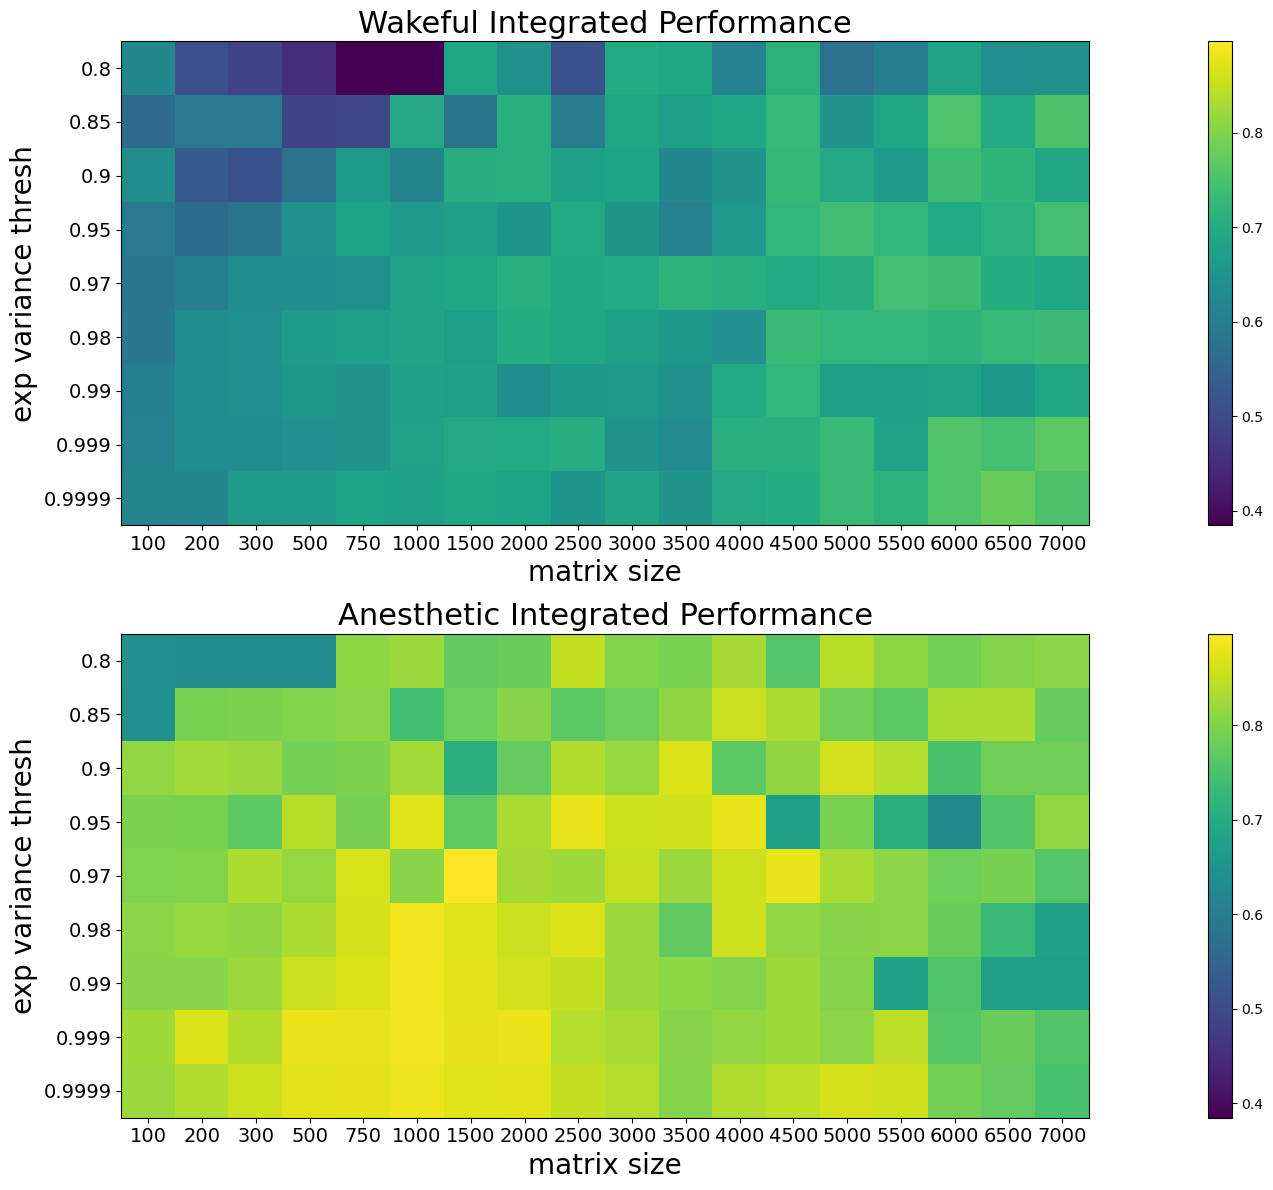

In [72]:
plt.figure(figsize=(24, 12))

norm = Normalize(vmin=np.min([wake_ip.min(), anesthesia_ip.min()]),vmax=np.max([wake_ip.max(), anesthesia_ip.max()]))

plt.subplot(2, 1, 1)
plt.imshow(wake_ip.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Wakeful Integrated Performance', fontsize=22)
plt.colorbar(ax=ax)

plt.subplot(2, 1, 2)
plt.imshow(anesthesia_ip.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Anesthetic Integrated Performance', fontsize=22)
plt.colorbar(ax= ax)
plt.tight_layout()
plt.show()

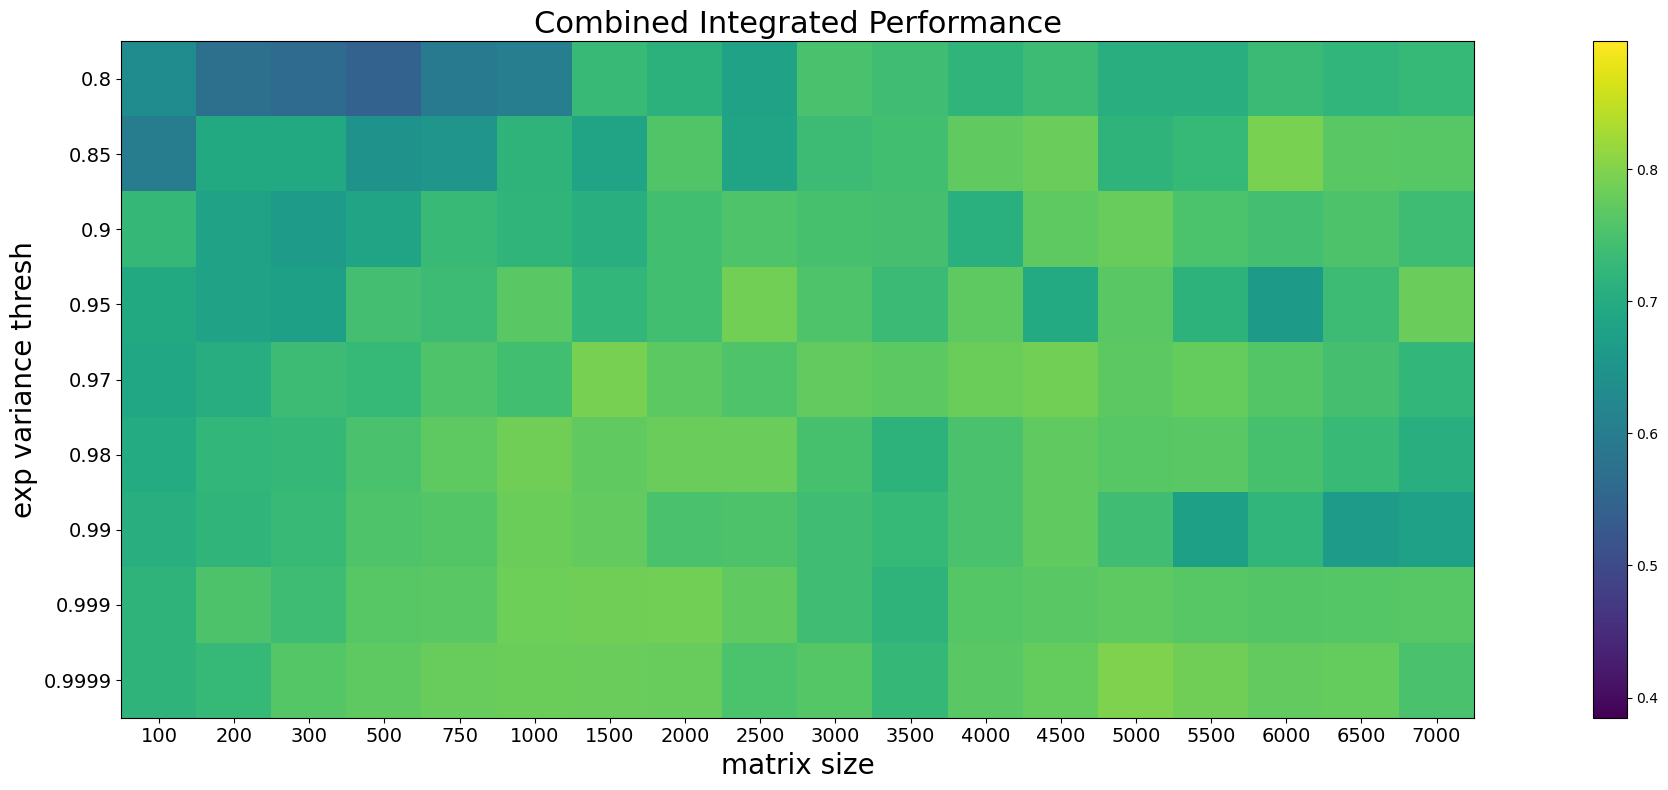

In [73]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=np.min([wake_ip.min(), anesthesia_ip.min()]),vmax=np.max([wake_ip.max(), anesthesia_ip.max()]))

plt.imshow((wake_ip.T + anesthesia_ip.T)/2, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Combined Integrated Performance', fontsize=22)
plt.colorbar(ax=ax)

plt.tight_layout()
plt.show()

In [74]:
wake_ip.shape

(18, 9)

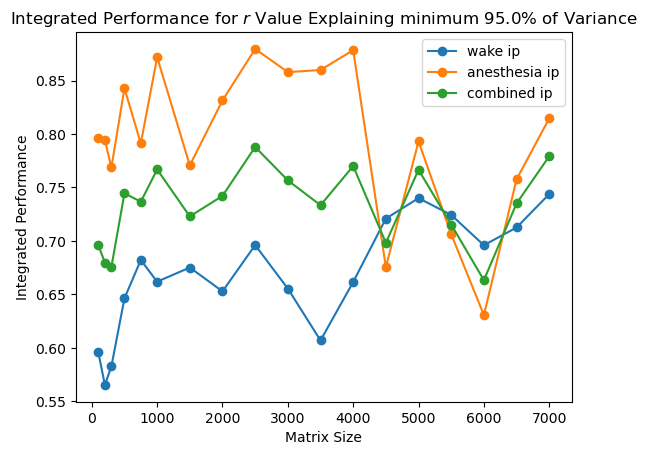

In [261]:
exp_variance_thresh = 0.95
plt.plot(matrix_size_vals, wake_ip.T[exp_variance_thresh_vals == exp_variance_thresh][0], marker='o', label='wake ip')
plt.plot(matrix_size_vals, anesthesia_ip.T[exp_variance_thresh_vals == exp_variance_thresh][0], marker='o', label='anesthesia ip')
plt.plot(matrix_size_vals, ((wake_ip.T + anesthesia_ip.T)/2)[exp_variance_thresh_vals == exp_variance_thresh][0], marker='o', label='combined ip')
plt.legend()
plt.xlabel('Matrix Size')
plt.ylabel('Integrated Performance')
plt.title(f'Integrated Performance for $r$ Value Explaining minimum {exp_variance_thresh*100}% of Variance')
plt.show()

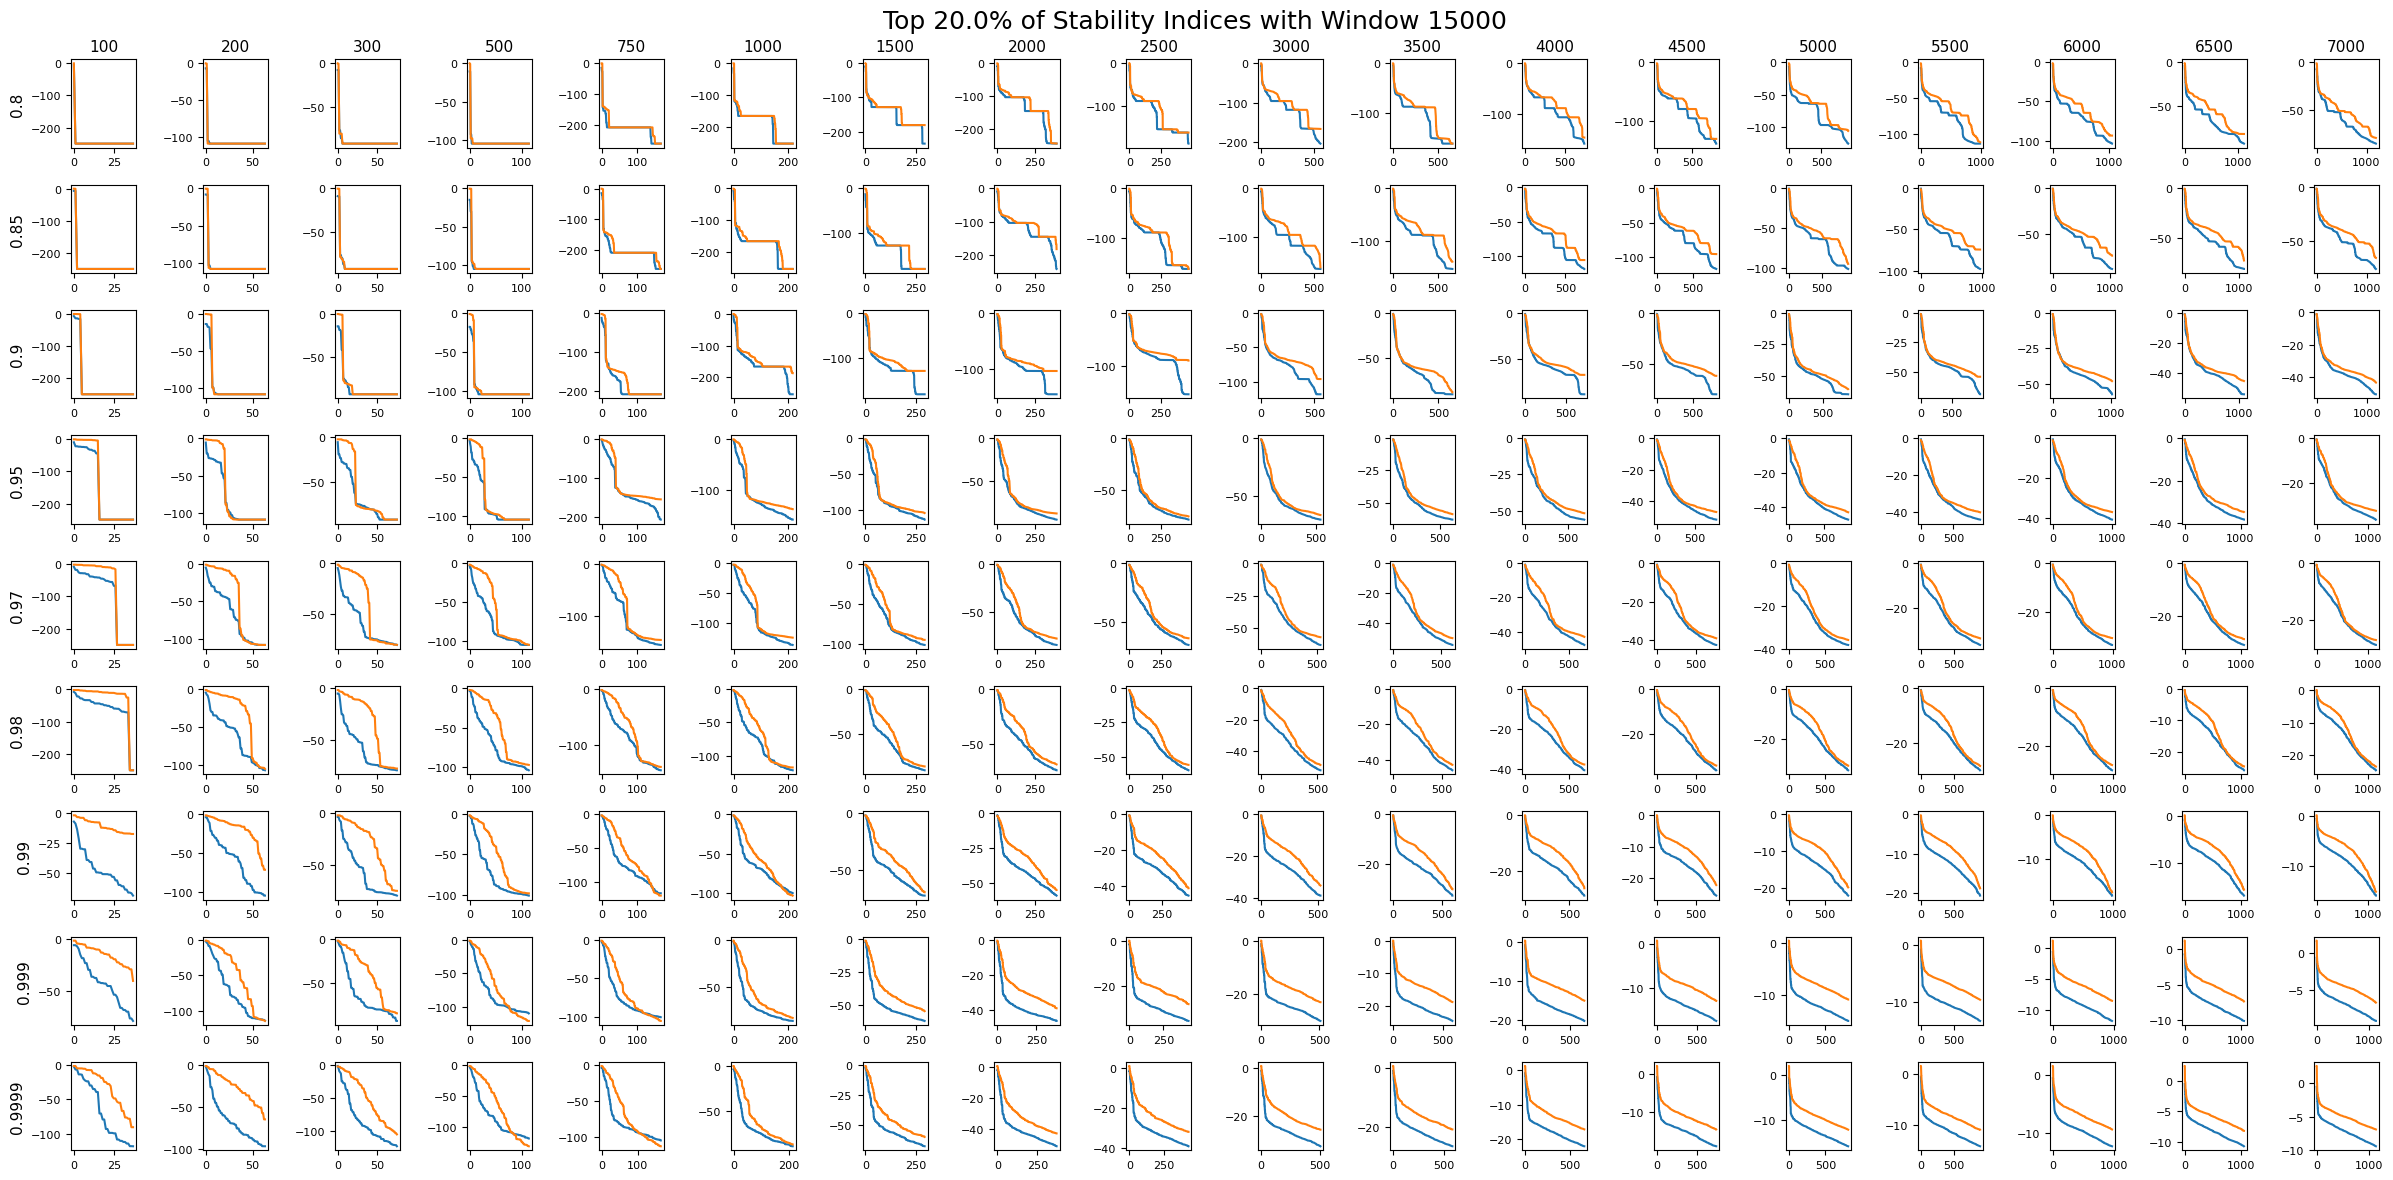

In [77]:
top_percent = 0.2
fig, axs = plt.subplots(len(exp_variance_thresh_vals), len(matrix_size_vals), figsize=(24, 12))
for i, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
    for j, matrix_size in enumerate(matrix_size_vals):
        ax = axs[i][j]
        ax.plot(wake_stab[(matrix_size, exp_variance_thresh)][:int(top_percent*len(wake_stab[(matrix_size, exp_variance_thresh)]))])
        ax.plot(anesthesia_stab[(matrix_size, exp_variance_thresh)][:int(top_percent*len(wake_stab[(matrix_size, exp_variance_thresh)]))])
        if i == 0:
            ax.set_title(f'{matrix_size}', fontsize=11)
        if j == 0:
            ax.set_ylabel(f'{exp_variance_thresh}', fontsize=11)
        ax.tick_params(labelsize=8)
plt.suptitle(f'Top {top_percent*100}% of Stability Indices with Window {window}', fontsize=18)
plt.tight_layout()
plt.show()

# False Nearest Neighbour Analysis

In [282]:
def get_nn_indices(pts, time_step_bound=10, sample_indices=None, p=2):
    if sample_indices is None:
        sample_indices = np.arange(pts.shape[0] - 1)
    kdTree = spatial.cKDTree(pts[:-1])
    nn_dist, nn_inds = kdTree.query(embedding[sample_indices], k=2*time_step_bound + 1, p=p)
    nn_indices = np.zeros(nn_inds.shape[0], dtype=int)
    nn_distances = np.zeros(nn_dist.shape[0])
    for i in range(nn_indices.shape[0]):
        nn_num = np.argmax(np.abs(nn_inds[i] - sample_indices[i]) >= time_step_bound)
        nn_indices[i] = nn_inds[i][nn_num]
        nn_distances[i] = nn_dist[i][nn_num]
    return nn_indices, nn_distances, sample_indices

def get_metric(p, name=False):
    if p == 1:
        if name:
            return "cityblock"
        return spatial.distance.cityblock
    elif p == 2:
        if name:
            return "euclidean"
        return spatial.distance.euclidean
    elif p == np.Inf:
        if name:
            return "chebyshev"
        return spatial.distance.chebyshev
    else:
        if name:
            return "minkowski"
        return lambda u, v: spatial.distance.minkowski(u, v, p=p)

def calculate_fnn_stat(pts, nn_indices, r, sample_indices=None, p=2, verbose=True):
    if sample_indices is None:
        sample_indices = np.arange(pts.shape[0])
    
    metric = get_metric(p)

    N = pts.shape[0]
    nn_distances = []
    nn_next_step_distances = []

    for ind in tqdm(range(len(sample_indices)), disable=not verbose):
        i = sample_indices[ind]
        j = nn_indices[ind]
        if i + 1 < N and j + 1 < N:
            nn_distance = metric(pts[i], pts[j])
            if nn_distance == 0:
                nn_distances.append(1)
                nn_next_step_distances.append(np.Inf)
            else:
                nn_distances.append(nn_distance)
                nn_next_step_distances.append(metric(pts[i + 1], pts[j + 1]))
    nn_distances, nn_next_step_distances = np.array(nn_distances), np.array(nn_next_step_distances)
    ratios = nn_next_step_distances / nn_distances
    fraction_greater = np.sum(ratios > r) / len(ratios)
    return fraction_greater, ratios

In [272]:
m_vals = np.array([int(np.ceil(matrix_size/len(unit_indices))) for matrix_size in matrix_size_vals])
m_vals = np.hstack([1, m_vals])
fraction_fnn = np.zeros(m_vals.shape)

In [273]:
m_vals

array([  1,   2,   4,   5,   8,  12,  16,  24,  32,  40,  47,  55,  63,
        71,  79,  86,  94, 102, 110])

In [274]:
m_vals = m_vals[:10]

In [275]:
signals = {'wake': wake_signal, 'anesthesia': anesthesia_signal}

In [283]:
num_samples = 1000
time_step_bound = 10
r=1.06
fnn_stats = np.zeros((len(signals), len(m_vals)))
ratio_arrays_all = np.zeros((len(signals), len(m_vals), num_samples))
iterator = tqdm(total=len(signals)*len(m_vals))
for i, (key, signal) in enumerate(signals.items()):
    for j, m in enumerate(m_vals):
        embedding = embed_signal((signal - signal.mean())/signal.std(), m, tau=1)
        sample_indices = np.random.choice(np.arange(embedding.shape[0] - 1), size=(num_samples, ), replace=False)
        nn_indices, _, sample_indices = get_nn_indices(embedding, time_step_bound, sample_indices, p=p)
        fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, sample_indices=sample_indices, p=p, verbose=False)
        fnn_stats[i, j] = fraction_greater
        ratio_arrays_all[i, j] = ratios
        
        iterator.update()
iterator.close()

  0%|          | 0/20 [00:00<?, ?it/s]

In [288]:
fnn_curve = ((ratio_arrays_all > 1.0616).sum(axis=(0, 2))/(ratio_arrays_all.shape[0]*ratio_arrays_all.shape[2])).astype(float)

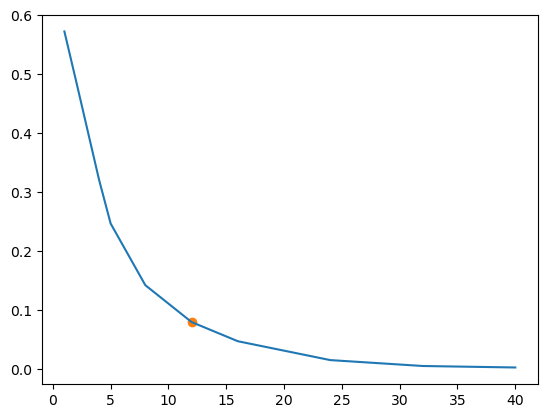

In [298]:

plt.plot(m_vals, fnn_curve)
ind = np.argmax(fnn_curve <= 0.1)
plt.scatter(m_vals[ind], fnn_curve[ind], c='C1')
plt.show()

In [254]:
min_length = np.min([len(ratio) for ratio in ratio_arrays])
ratio_arrays = np.array([ratio[:min_length] for ratio in ratio_arrays])

In [255]:
num_r_vals = 100
fnn_curves = np.zeros((num_r_vals, ratio_arrays.shape[0]))
for i, r in enumerate(np.linspace(ratio_arrays.min(), ratio_arrays.max(), num_r_vals)):
    fnn_curves[i] = (ratio_arrays > r).sum(axis=1)/min_length

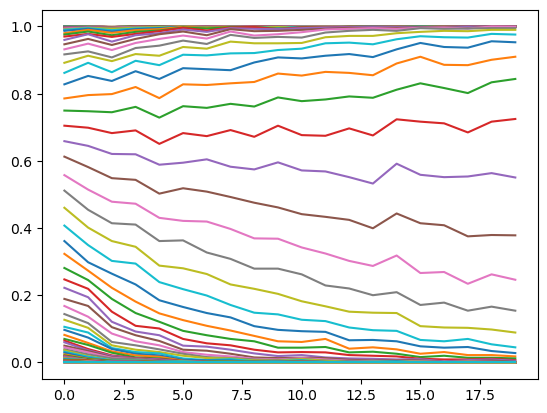

In [257]:
for i in range(100):
    plt.plot(fnn_curves[i])

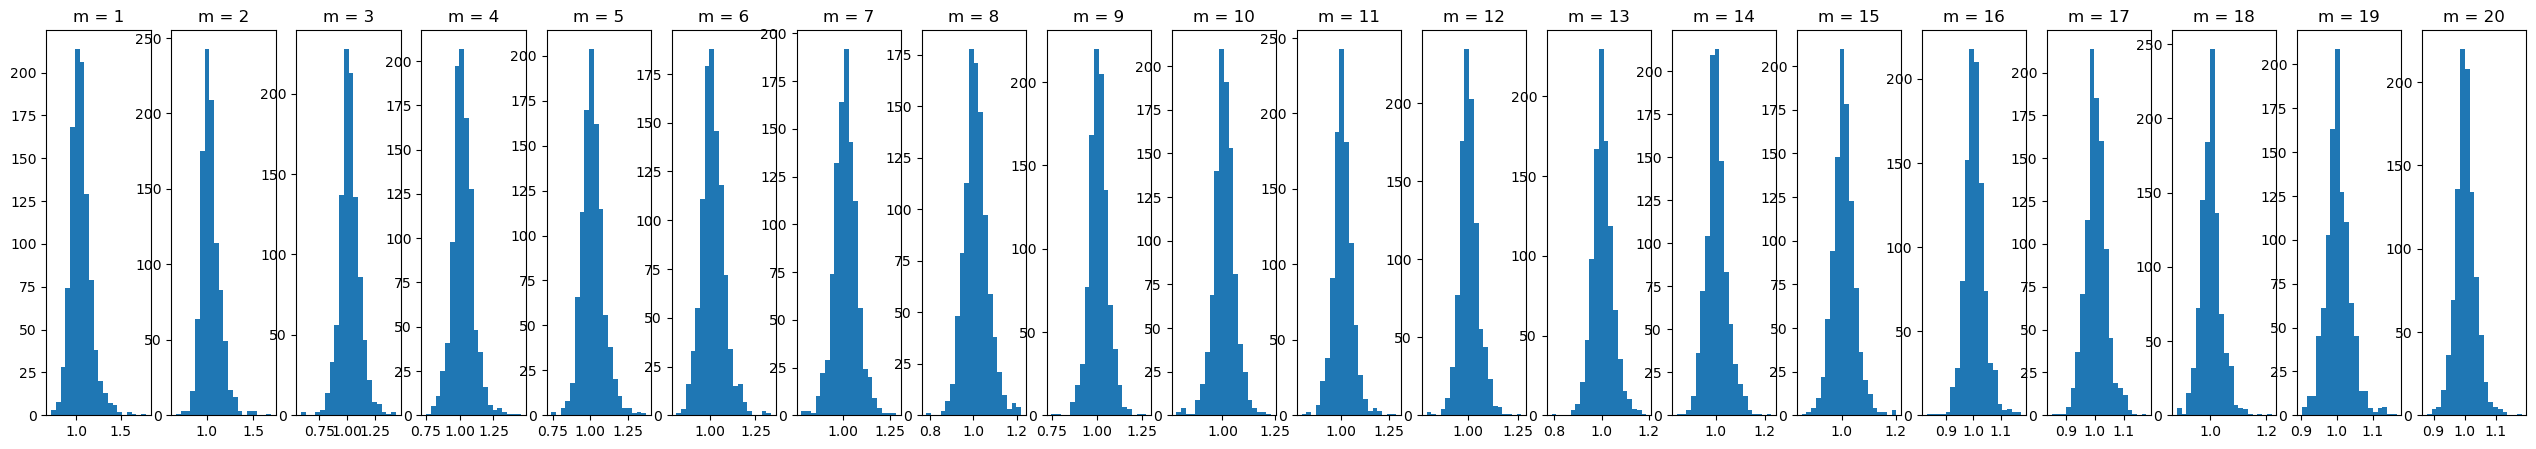

In [259]:
fig, axs = plt.subplots(1, len(ratio_arrays), figsize=(32, 5))
for i in range(len(ratio_arrays)):
    axs[i].hist(ratio_arrays[i], bins=20, label=f"m = {m_vals[i]}")
    axs[i].set_title(f"m = {m_vals[i]}")
plt.show()

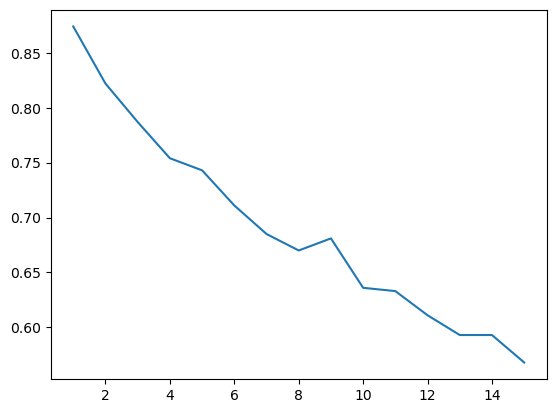

In [225]:
plt.plot(m_vals, fnn_stats)